In [2]:

import followthemoney as ftm
import followthemoney.model as model
import pandas
import json
import numpy as np
import math
from urllib import parse as url_parse
from pprint import pprint
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics as metrics 
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import seaborn as sb

# Importing and preprocessing

In [3]:
# local import for easier reproducibility 
json_path = "./data/meineabgeordneten_3.json"

def read_ftm_json(path):
    entity_dicts = []
    with open(path) as f:
        for line in f:
            entity_dicts.append(json.loads(line))
    return entity_dicts

entity_dicts = read_ftm_json(json_path)

In [4]:
person_dicts = [entity for entity in entity_dicts if entity["schema"] == "Person"]
ftm_proxies =[model.get_proxy(entity) for entity in entity_dicts]
ftm_persons = [proxy for proxy in ftm_proxies if proxy.schema.name == "Person"]
ftm_organizations = [proxy for proxy in ftm_proxies if proxy.schema.name == "Organization"]
ftm_companies = [proxy for proxy in ftm_proxies if proxy.schema.name == "Company"]
person_assignments = pandas.read_csv("./data/csv/new/Person_wikidata.csv")[["id", "wikidata"]]


In [5]:
person_assignments

,id,wikidata
0,00023638949ec143e690ae151d28e389574f07dc,Q51533040
1,001d48bf2913572202d88f00e35262f490771b40,Q81526090
2,00ad3c5b5a651f6e00080803ffefb1d306c6d027,Q20752545
3,00def69ad3d13efe8151da80f1485a692954d183,Q102353097
4,00e70efc17aff680e675349ca87d7b80be04c452,Q50843964
...,...,...
761,fcc94a122228733902b6f601abc54631aa205a4b,Q54956531
762,fd6b5ddebf7ed34449bac5a96eb2acbdbf5e4a3e,Q84091498
763,fdc8f2275cf8bea8331ea4a779755915d0c29363,NaN
764,fe532c498a07fc06380579af855e68389239c43b,Q19501935


In [6]:
print(len(ftm_persons), len(person_assignments))

766 766


All properties of entities are multivalued, although they mostly hold only one single value. I transform the data in order to call the API with single-valued properties.

In [7]:
def entity2df(entities):   
    flat_entities = []
    for entity in entities:
        prop_dict ={}
        for prop, val in entity.properties.items():
            prop_dict["id"] = entity.id
            prop_dict[prop] = val[0] if len(val)== 1 else  val
        flat_entities.append(prop_dict)
    return pandas.DataFrame.from_dict(flat_entities)




In [8]:
# Dataframe with Wikidata Cells
clean_person_df = entity2df(ftm_persons).merge(person_assignments,on="id")
clean_person_df

,id,birthDate,birthPlace,country,email,firstName,lastName,name,sourceUrl,summary,website,title,wikidata
0,00023638949ec143e690ae151d28e389574f07dc,1987-02-23,Innsbruck,at,buero.wohlgemuth@oegb.at,Philip,Wohlgemuth,Philip Wohlgemuth,https://www.meineabgeordneten.at/Abgeordnete/p...,Abgeordneter zum Landtag,"[https://www.instagram.com/philip_wohlgemuth/,...",NaN,Q51533040
1,001d48bf2913572202d88f00e35262f490771b40,1976-06-25,Wiener Neustadt,at,waltraud.ungersboeck@noel.gv.at,Waltraud,Ungersböck,Waltraud Ungersböck,https://www.meineabgeordneten.at/Abgeordnete/W...,"[Vizebürgermeisterin, Verein der Eltern und Fr...",[https://www.facebook.com/profile.php?id=10001...,NaN,Q81526090
2,00ad3c5b5a651f6e00080803ffefb1d306c6d027,1971-02-27,Rottenmann,at,armin.forstner@stvp.at,Armin,Forstner,Armin Forstner,https://www.meineabgeordneten.at/Abgeordnete/a...,"[Steirischer Zivilschutzverband, Abgeordneter ...",https://www.facebook.com/a.forstner/,NaN,Q20752545
3,00def69ad3d13efe8151da80f1485a692954d183,1980-10-20,Wien,at,spassfabrik@gmx.at,Silvia,Janoch,Silvia Janoch,https://www.meineabgeordneten.at/Abgeordnete/s...,"[KINDERGRUPPE SPASSFABRIK, Schriftführerin des...",https://www.facebook.com/silvia.janoch,Dipl.-Päd.,Q102353097
4,00e70efc17aff680e675349ca87d7b80be04c452,1970-07-10,Eisenstadt,at,elvira.schmidt@spoe.at,Elvira,Schmidt,Elvira Schmidt,https://www.meineabgeordneten.at/Abgeordnete/e...,"[Mitglied des Gemeinderates, Abgeordnete zum L...",https://www.facebook.com/virli.schmidt,NaN,Q50843964
...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,fcc94a122228733902b6f601abc54631aa205a4b,1963-01-16,Radstadt,at,liesl.weitgasser@neos.eu,Elisabeth,Weitgasser,Elisabeth Weitgasser,https://www.meineabgeordneten.at/Abgeordnete/e...,"[S-berg Hotel Ges.m.b.H., Abgeordnete zum Land...","[https://www.facebook.com/liesl.weitgasser, ht...",NaN,Q54956531
762,fd6b5ddebf7ed34449bac5a96eb2acbdbf5e4a3e,1966-11-04,Wien,at,elisabeth.trummer.spoe@gmail.com,Elisabeth,Trummer,Elisabeth Trummer,https://www.meineabgeordneten.at/Abgeordnete/e...,"[""Verein zur Erhaltung und Erneuerung der Infr...",https://www.facebook.com/Trummerelisabeth,NaN,Q84091498
763,fdc8f2275cf8bea8331ea4a779755915d0c29363,NaN,NaN,at,daniela.schmid@ages.at,Daniela,Schmid,Daniela Schmid,https://www.meineabgeordneten.at/Abgeordnete/d...,NaN,NaN,Priv.-Doz.in Dr.in,NaN
764,fe532c498a07fc06380579af855e68389239c43b,1964-06-30,Graz,at,andrea-michaela.schartel@parlament.gv.at,Andrea Michaela,Schartel,Andrea Michaela Schartel,https://www.meineabgeordneten.at/Abgeordnete/A...,"[Mitglied des Bundesrates, Österreichischer Ka...",[https://www.facebook.com/Andrea-Michaela-Scha...,NaN,Q19501935


# Reconciliation

In [9]:
import requests
import urllib
reconciliation_endpoint = urllib.parse.urlparse("https://wikidata.reconci.link/de/api")
suggest_endpoint = urllib.parse.urlparse("https://wikidata.reconci.link/de/suggest")


Ontology alignment was statically performed with 3 variations. At the first mapping (mapping_full) all available properties are mapped according to Wikidata, if a corresponding property existed. In the second one, properties that are seldomoly existent in Wikidata were omitted. In the last one, a minimal set of properties were mapped to evaluate the scoring mechanism.

In [10]:
mapping_full = {
    "birthDate" : "P569",
    "birthPlace" : "P19",
    "email" : "P968",
    "firstName" : "P735",
    "lastName" : "P734",
    "title" : "P512",
    "website" : "P856"
}

In [11]:
mapping_refined = {
    "birthDate" : "P569",
    "birthPlace" : "P19",
    #"email" : "P968",
    "firstName" : "P735",
    "lastName" : "P734",
    "title" : "P512",
    #"website" : "P856"
}

In [12]:
mapping_sparse = {
    "birthDate" : "P569",
}

In [13]:
def createQuery(entity, type, mapping, limit = 10):
    query_params = {}
    query_params["query"] = entity.first("name")
    query_params["type"] = type
    query_params["properties"] = []
    query_params["limit"] = limit # candidate limit
    for prop, value in entity.properties.items():
        #print(prop, mapping.get(prop))
        wikidataId = mapping.get(prop)
        if wikidataId:
            prop = {"pid": wikidataId, "v": value[0] if len(value)== 1 else  value}
            query_params["properties"].append(prop)   
 
    return query_params
    


In [14]:
createQuery(ftm_persons[3], "Q5", mapping_sparse)

{'query': 'Silvia Janoch',
 'type': 'Q5',
 'properties': [{'pid': 'P569', 'v': '1980-10-20'}],
 'limit': 10}

In [15]:
def create_batch_queries(entities, type, mapping, batch_size = 10):
    start = 0
    end = 0 + batch_size
    batches =[]
    for batch_nr in range(math.ceil(len(entities)/batch_size)):
        queries = {"q"+str(i):createQuery(entity, type, mapping) for i, entity in enumerate(ftm_persons[start:end])}
        batches.append(queries)
        start += batch_size
        end += batch_size
    return batches
    

In [16]:
def query_endpoint(query_batches):
    results = []
    for batch_query in query_batches:
        response = requests.post(reconciliation_endpoint.geturl(), data = {"queries": json.dumps(batch_query)})
        results.extend([resp for index, resp in response.json().items()])
    return results

For each mapping a distinct dataset is created. Due to reproducibility reasons, the API results are persisted. Also, each batch query processing takes approximately 3 minutes, making 9 minutes in total.

In [17]:
get_path =  lambda name: "./data/intermediate/api_responses_{}.json".format(name)

def query_and_persist(entities, type, mapping, name):
    batch_queries = create_batch_queries(ftm_persons, "Q5", mapping) 
    results = query_endpoint(batch_queries)
    json.dump(results, open(get_path(name),"w"))
    return results

In [21]:
%%time

if False:
    # Q5 is the Wikidata ID for type "Human".
    results_full = query_and_persist(ftm_persons, "Q5", mapping_full, "mapping_full") 
    results_refined = query_and_persist(ftm_persons, "Q5", mapping_refined, "mapping_refined") 
    results_sparse = query_and_persist(ftm_persons, "Q5", mapping_sparse, "mapping_sparse") 
    
else:
    
    results_full = json.load(open(get_path("mapping_full")))
    results_refined = json.load(open(get_path("mapping_refined")))
    results_sparse = json.load(open(get_path("mapping_sparse")))
    #results = json.load(open("./data/intermediate/api_responses_without_email.json"))

CPU times: user 31.1 ms, sys: 0 ns, total: 31.1 ms
Wall time: 29.3 ms


# Analysis of the Record Linkage

Knitting together API response and data to create a pandas table for further processing. 

In [23]:
def create_cd_table(results, entities):
    intermed_table = []
    header = ["id", "name", "cd_wd_id", "cd_name","cd_match_pred", "cd_score", "comparison_vec"]
    for result, entity in zip(results, entities):
        candidates = result["result"]
        if len(candidates) > 0: 
            for candidate in candidates:
                intermed_table.append([entity.id,entity.first("name"), candidate["id"], candidate["name"], \
                    candidate["match"], candidate["score"], candidate["features"]])
        # If no results in response
        else: 
            intermed_table.append([entity.id,entity.first("name"), None, None, \
                False, None, None]) # implicit false made explicit

    cd_table = pandas.DataFrame(intermed_table, columns= header).merge(person_assignments,on="id")
    
    cd_table["match"] = cd_table["wikidata"] == cd_table["cd_wd_id"]
    cd_table["tp"] = cd_table["match"] & cd_table["cd_match_pred"]
    cd_table = cd_table.assign(rank = cd_table.groupby("id").cumcount().values + 1)
    return cd_table

cd_table_full = create_cd_table(results_full, ftm_persons)
cd_table_refined = create_cd_table(results_refined, ftm_persons)
cd_table_sparse = create_cd_table(results_sparse, ftm_persons)

Before calculating scores based on similarity measures, the Wikidata Reconciliation API performs a candidate selection based on the WikiMedia API Elasticsearch search-engine by querying the value in the "query" property inside the request, which corresponds to the name of an item (at least in the OpenRefine implementation, as well as here). Obviously, there is a high tendency to return just one matching result.

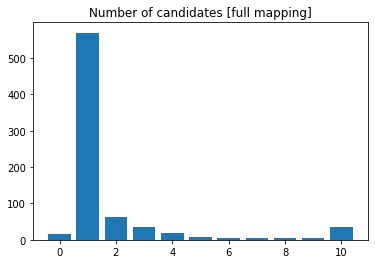

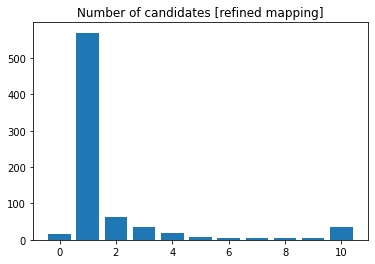

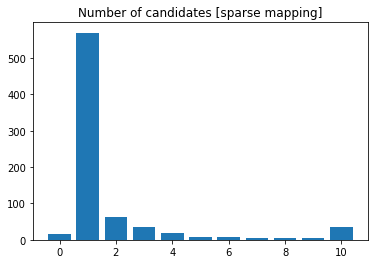

In [24]:

def num_cd_plt(api_results, description):
    cd_num_counts = pandas.DataFrame([len(result["result"]) for result in api_results], columns=["cd_num"])
    cd_occ_counts =  cd_num_counts.groupby("cd_num").size().to_frame("count")

    plt.bar(cd_occ_counts.index, cd_occ_counts["count"])
    plt.title("Number of candidates " + description)
    

num_cd_plt(results_full, "[full mapping]")
plt.show()
num_cd_plt(results_refined, "[refined mapping]")
plt.show()
num_cd_plt(results_sparse, "[sparse mapping]")

,name,cd_wd_id,cd_name,cd_match_pred,cd_score,wikidata,match
id,,,,,,,
00023638949ec143e690ae151d28e389574f07dc,Philip Wohlgemuth,Q51533040,Philip Wohlgemuth,True,86.666667,Q51533040,True
001d48bf2913572202d88f00e35262f490771b40,Waltraud Ungersböck,Q81526090,Waltraud Ungersböck,True,86.666667,Q81526090,True
00ad3c5b5a651f6e00080803ffefb1d306c6d027,Armin Forstner,Q20752545,Armin Forstner,True,73.333333,Q20752545,True
00def69ad3d13efe8151da80f1485a692954d183,Silvia Janoch,Q102353097,Silvia Janoch,False,52.941176,Q102353097,True
00e70efc17aff680e675349ca87d7b80be04c452,Elvira Schmidt,Q50843964,Elvira Schmidt,True,86.666667,Q50843964,True
...,...,...,...,...,...,...,...
fcc94a122228733902b6f601abc54631aa205a4b,Elisabeth Weitgasser,Q54956531,Elisabeth Weitgasser,True,73.333333,Q54956531,True
fd6b5ddebf7ed34449bac5a96eb2acbdbf5e4a3e,Elisabeth Trummer,Q84091498,Elisabeth Trummer,True,86.666667,Q84091498,True
fdc8f2275cf8bea8331ea4a779755915d0c29363,Daniela Schmid,Q87653139,Daniela Schmid,False,81.818182,NaN,False


As the data is about person of interests, it is heavly biased towards well known entities that actually have a Wikidata (and Wikipedia) page, which corresponds to the scenario layed out in the thesis.

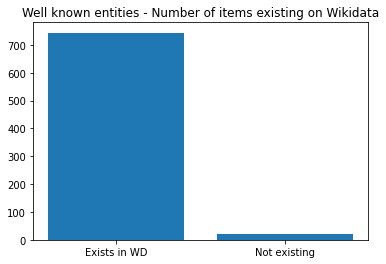

In [25]:

def well_known_count(cd_table):
    cd_first_candidate = cd_table.groupby("id").first()
    has_match = ~cd_first_candidate["wikidata"].isna()
    has_match.value_counts()
    plt.bar(["Exists in WD", "Not existing"],has_match.value_counts())
    plt.title("Well known entities - Number of items existing on Wikidata")
well_known_count(cd_table_full)


## Overview 
The threshold of Wikidata's Reconciliation Service was automatically set by the service, following this equation:

$t = t_{val} - d \cdot |p| = 95 - 5 \cdot |p|$

where:<br>
$t_{val}$ ... the fixed validation threshold set by the service. This value is statically set to 95<br>
$d$ ... The fixed validation discount set by the service. This value is statically set to 5 <br>
$p$ ... The set of properties queried


Candidates that exceeded this threshold are considered as a match. Other candidates returned demand further human judgment. The service does not offer partial matches, which would require a second (lower) threshold. However, the service reveals candidate to the user for further judgement. The size of candidates is limited to 10 Candidates for this case. 

Record Linkage regarding Wikidata may return a maximum of 1 match, as Wikidata itself generally does not hold duplicates (although there are exceptions).


# Evaluating Matching decisions 
Firstly, filter out cases, where no Wikidata item exists, as there are no relevant entities, which are needed for computing precision and recall measures. In this case 21 entities are filtered out.

In [26]:
cd_full = cd_table_full[~cd_table_full["wikidata"].isna()]
cd_refined = cd_table_refined[~cd_table_refined["wikidata"].isna()]
cd_sparse = cd_table_sparse[~cd_table_sparse["wikidata"].isna()]

### Overview regarding matching decision
Overview on the decisions of the service: Most decisions are true positives. If not in virtually any case, the true entity was in the set of candidate revealed by the service. There are major differences regarding the data.

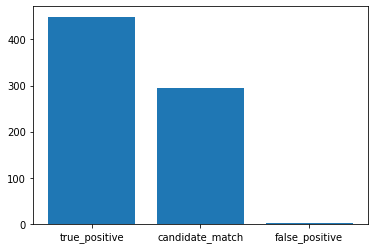

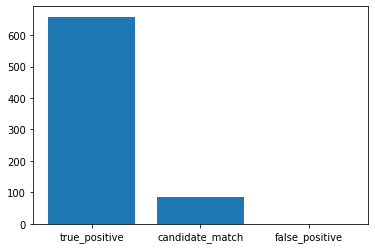

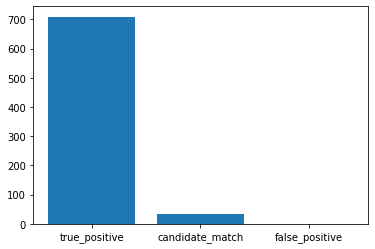

In [27]:
def matching_overview(cd):
    any_cd_match = cd[["match", "tp"]].groupby(cd["id"]).any()#.to_frame("any_cd_match")
    any_cd_match["match_category"] = np.select([
        any_cd_match["match"] & any_cd_match["tp"],
        any_cd_match["match"]
    ],[ "true_positive", "candidate_match"], default="false_positive")
    any_cd_match["match_category"].value_counts()

    match_category = any_cd_match["match_category"].value_counts()
    plt.bar(match_category.index,match_category)

matching_overview(cd_full)
plt.show()
matching_overview(cd_refined)
plt.show()
matching_overview(cd_sparse)
plt.show()


In [28]:
# TODO: do i need this?
#cd["cd_wd_id"] = cd["cd_wd_id"].astype(str)
#cd["wikidata"] = cd["wikidata"].astype(str)

## Macro Averaged Precision and Recall

In [29]:
cd_full["match"].value_counts()



True     743
False    660
Name: match, dtype: int64

Due to the balanced classes distribution in dataset of candidates, I choosed MACRO averaged metrics.

In [30]:
def avg_metrics(cd):
    cd_metrics = []
    for name, query in cd.groupby("id"):
        metric = { 
            "acc": metrics.accuracy_score(query["cd_match_pred"], query["match"]),
            "prec": metrics.precision_score(query["cd_match_pred"], query["match"], average="macro", zero_division=0 ),
            "rec": metrics.recall_score(query["cd_match_pred"], query["match"], average="macro",zero_division=0)
        }
        #prec = metrics.accuracy_score(query["cd_match_pred"].values,query["match"].values)
        cd_metrics.append(metric)
    return pandas.DataFrame(cd_metrics).mean()
    #print(len(query))

#https://stats.stackexchange.com/questions/8025/what-are-correct-values-for-precision-and-recall-when-the-denominators-equal-0

As we can see, the matching algorithm is poor. The more data is transmitted to the reconciliation API, the weaker are the results, due to more comparison scores evaluate to 0 even though it should be the opposite.

In [31]:
macro = {
    "full": avg_metrics(cd_full),
    "refined": avg_metrics(cd_refined),
    "sparse": avg_metrics(cd_sparse)
}
pprint(macro)

{'full': acc     0.644812
prec    0.634409
rec     0.624826
dtype: float64,
 'refined': acc     0.903878
prec    0.897849
rec     0.894815
dtype: float64,
 'sparse': acc     0.959562
prec    0.957661
rec     0.956931
dtype: float64}


In [32]:
ERROR = {
    "full": 1- macro["full"].loc["acc"],
    "refined": 1- macro["refined"].loc["acc"],
    "sparse": 1- macro["sparse"].loc["acc"]
}
ERROR

{'full': 0.3551875320020482,
 'refined': 0.09612241850145076,
 'sparse': 0.040438321385901976}

In [33]:
def fp(cd):
    fp = cd["cd_match_pred"] & ~cd["match"]
    return fp.value_counts()
{
    "full" : fp(cd_full),
    "refined" : fp(cd_refined),
    "sparse" : fp(cd_sparse)
    }

{'full': False    1403
 dtype: int64,
 'refined': False    1403
 dtype: int64,
 'sparse': False    1404
 dtype: int64}

## Evaluating the Ranking
The Wikidata Reconciliation API makes rather conservative decisions, surfacing no false positives, but many false negatives. In this case, false positives would be worse, as we would create an inconsistent entity instead of just an incomplete one. Still, in many cases the right item was inside the list of candidates - mostly at the very top. As the service was built for additional human judgement, the ranking of the candidates is of utmost importance.

### Mean Reciprocal Rank
The [mean reciprocal rank](https://en.wikipedia.org/wiki/Mean_reciprocal_rank) takes the positition of the FIRST relevant item into account. This makes sense here, as we have a maximum of 1 match. We want to score higher if the match is at position 1 (rr= 1/1) than if it is at rank 3 (1/3).

$MRR = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \frac{1}{rank_i}$

Considering this, the reconciliation API returns good results, which indicates that the scoring threshold could be lower.

In [34]:
def mrr(cd):
    cd_first = cd_first= cd.groupby("id").first()
    hits = cd[cd["match"]]
    eliminated_all_false_results = len(cd_first) - len(hits) 
    mrr = (1 / hits["rank"]).sum() / len(cd_first)
    return mrr

{"full": mrr(cd_full), 
"refined": mrr(cd_refined),
"sparse": mrr(cd_sparse)}

{'full': 0.9973118279569892,
 'refined': 0.9973118279569892,
 'sparse': 0.9969086021505377}

### Metrics @1


In [42]:
def metrics_at_1(cd):
    cd_first= cd.groupby("id").first()
    cd_first_metrics = { 
        "acc": metrics.accuracy_score(cd_first["cd_match_pred"], cd_first["match"]),
        "prec": metrics.precision_score(cd_first["cd_match_pred"], cd_first["match"],average="macro"),
        "rec": metrics.recall_score(cd_first["cd_match_pred"], cd_first["match"])
    }
    return cd_first_metrics
{
    "full":metrics_at_1(cd_full),
    "refined":metrics_at_1(cd_refined),
    "sparse":metrics_at_1(cd_sparse)
    }


{'full': {'acc': 0.6075268817204301, 'prec': 0.8029689608636976, 'rec': 1.0},
 'refined': {'acc': 0.8884408602150538,
  'prec': 0.9439946018893388,
  'rec': 1.0},
 'sparse': {'acc': 0.956989247311828, 'prec': 0.9784075573549258, 'rec': 1.0}}

In [43]:
conf_matr_first = lambda first: metrics.confusion_matrix(first["match"], first["cd_match_pred"])
conf_matr = conf_matr_first(cd_first)

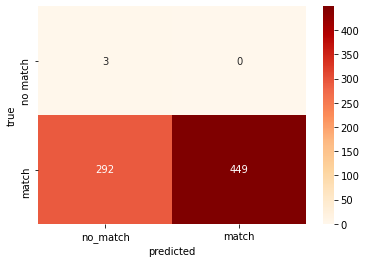

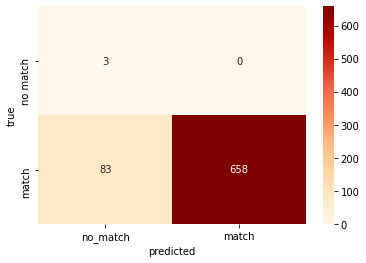

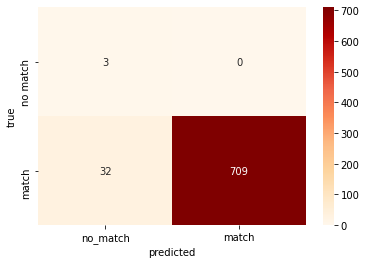

In [46]:

def plot_conf_matr(cd):
    cd_first= cd.groupby("id").first()
    conf_matr  = metrics.confusion_matrix(cd_first["match"], cd_first["cd_match_pred"])
    
    df =pandas.DataFrame(conf_matr)
    df.columns = ["no_match", "match"]
    df.index = ["no match", "match"]
    #df = df[["match", "partial_match", "no_match"]]
    # Subscript of confusion matrix due to the fact that the estimator has more classes than the actual label. 
    sb.heatmap(df, annot=True,cmap="OrRd", fmt="g")
    plt.xlabel("predicted")
    plt.ylabel("true")

plot_conf_matr(cd_full)
plt.show()
plot_conf_matr(cd_refined)
plt.show()
plot_conf_matr(cd_sparse)


## Quick overview over the linear dependencies

In [47]:
def list2dict(row):
    dic = {}
    #dic["name"] = row["name"] 
    #dic["cd_name"] = row["cd_name"] 
    
    if not row["comparison_vec"]:
        return
    for el in row["comparison_vec"]:
        dic[el["id"]] = el["value"]
        

    return dic

comparison_dicts =  cd_table_full.apply(lambda x: list2dict(x), axis=1)#.to_list()
comparison_vecs = pandas.DataFrame(comparison_dicts[~comparison_dicts.isna()].to_list())#.assign(match = cd_table_full["match"].astype

In [48]:
mapping_full

{'birthDate': 'P569',
 'birthPlace': 'P19',
 'email': 'P968',
 'firstName': 'P735',
 'lastName': 'P734',
 'title': 'P512',
 'website': 'P856'}

As one may expect, the date of birth contribute strongest to the decision, followed by the name (found in "all_labels"). This rather low contribution of the name results from the bias introduced by the search beforhand, which queried the name.

In [49]:
lm = LinearRegression().fit(comparison_vecs.fillna(0)/100, 
        cd_table_full["match"][~cd_table_full["comparison_vec"].isna()])
pandas.DataFrame(lm.coef_, index=comparison_vecs.columns).T


,P569,P19,P968,P735,P734,P856,all_labels,P512
0,0.895523,0.059094,1.942890e-16,0.003001,-0.006066,0.0,0.233345,-0.037565


# Ontology Alignment: Suggestion API
To assess to suggestion capabilities of the API, I will look into the results

In [51]:
everypolitician_dicts = read_ftm_json("./data/everypolitician.json")
ftm_everypolitician =[model.get_proxy(entity) for entity in everypolitician_dicts if entity["schema"] == "Person"]


In [53]:
df_evplt = entity2df(ftm_everypolitician)

In [55]:
intersection = clean_person_df[np.in1d(clean_person_df["wikidata"],df_evplt["wikidataId"])]

In [56]:
intersection

,id,birthDate,birthPlace,country,email,firstName,lastName,name,sourceUrl,summary,website,title,wikidata
8,034bf9079555c4722e42de16b6b0c9dc3bef12ca,1981-10-16,"Kulu, Türkei",at,dialogbuero.wien@gruene.at,Aygül Berîvan,Aslan,Aygül Berîvan Aslan,https://www.meineabgeordneten.at/Abgeordnete/A...,[Österreichische Gesellschaft zur Förderung de...,"[https://www.instagram.com/berivan_aslan/, htt...",Mag.a,Q15792244
12,0481dce38b1207403942d8bdfe7c21fea65c422b,1985-03-19,Rum,at,sigi.maurer@gruene.at,Sigrid,Maurer,Sigrid Maurer,https://www.meineabgeordneten.at/Abgeordnete/S...,Abgeordnete zum Nationalrat,"[https://www.facebook.com/sigrid.maurer, https...",NaN,Q1618939
17,05f306ebe8d37ce924b72b1520cff592093907c4,1976-02-27,Salzburg,at,conny.ecker@gmail.com,Cornelia,Ecker,Cornelia Ecker,https://www.meineabgeordneten.at/Abgeordnete/C...,"[Mitglied der Gemeindevertretung, Jugend am We...","[https://www.facebook.com/conny.ecker.spoe, ht...",NaN,Q15616501
24,079f985b4d42a1f0c710b529f5d237007f1ee569,1966-01-04,Friesach,at,kassegger@bloomix.at,Axel,Kassegger,Axel Kassegger,https://www.meineabgeordneten.at/Abgeordnete/A...,"[Holding Graz-Kommunale Dienstleistungen GmbH,...",https://www.facebook.com/profile.php?id=100010...,MMMag. Dr.,Q15784856
27,07ec13b200e35f2ab851c3853b897102d745d90a,1967-08-21,Lang (Steiermark),at,josef.muchitsch@parlament.gv.at,Josef,Muchitsch,Josef Muchitsch,https://www.meineabgeordneten.at/Abgeordnete/J...,"[BUAK Betriebliche Vorsorgekasse GesmbH, Abgeo...","[https://twitter.com/JosefMuchitsch, https://w...",NaN,Q1705321
...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,e91ee97e5e74be32acf69dce1d2b423bb84e772c,1956-10-07,Wien,at,johannes.huebner@fpoe.at,Johannes,Hübner,Johannes Hübner,https://www.meineabgeordneten.at/Abgeordnete/J...,"[PHB Immobilienverwertungsgesellschaft m.b.H.,...",NaN,Dr.,Q1522895
699,e929bcf4f4571033026213714b7733d6d432aa33,1961-10-14,St. Pölten (Niederösterreich),at,wolfgang.gerstl@parlament.gv.at,Wolfgang,Gerstl,Wolfgang Gerstl,https://www.meineabgeordneten.at/Abgeordnete/W...,"[Österreichische Blindenwohlfahrt, Abgeordnete...","[https://www.facebook.com/wgerstl/, https://tw...",Mag.,Q2589687
734,f3ed38b4bc091f39b1596232109b73149f0e4af3,1968-06-19,Waidhofen/Ybbs,at,mail@andreas-hanger.at,Andreas,Hanger,Andreas Hanger,https://www.meineabgeordneten.at/Abgeordnete/A...,"[Wirtschaftspark Ybbstal GmbH, Österreichische...","[https://www.instagram.com/andreas_hanger/, ht...",Mag.,Q15783312
738,f6311c1d51c86d3ec3c8b9438d0092cfcb4cfe96,1956-01-28,Wien,at,ruth.becher@parlament.gv.at,Ruth,Becher,Ruth Becher,https://www.meineabgeordneten.at/Abgeordnete/R...,"[Verein Donaustädter Sport- und Kulturwochen, ...",NaN,Mag.a,Q2177565


In [ ]:
ftm.

In [770]:
response = requests.get(suggest_endpoint.geturl() + "/type" + "?prefix=entity" )

In [771]:
response.content

b'{"result":[{"description":"Entit\\u00e4t mit begrenztem Territorium, die zu administrativen Zwecken bestimmt wurde","id":"Q56061","name":"administrativ-territoriale Entit\\u00e4t"},{"description":"etwas, das existiert","id":"Q35120","name":"Entit\\u00e4t"},{"description":"Wikimedia-Begriffskl\\u00e4rungsseite","id":"Q395312","name":"Entit\\u00e4t"},{"description":"Album von Origin","id":"Q3055100","name":"Entity"},{"description":"2014 debut studio album by Oscar and the Wolf","id":"Q63020308","name":"Entity"},{"description":"Wikimedia-Begriffskl\\u00e4rungsseite","id":"Q8776407","name":"Entity"},{"description":"thriller von 2012","id":"Q16991800","name":"Entity"}]}'

In [736]:
import followthemoney_enrich as enrich

In [742]:
wd_enrich = enrich.get_enricher("opencorporates")

In [748]:
p = enrich.AlephEnricher().convert_entity(ftm_persons)

In [750]:
p == None

True